In [5]:
!pip install --upgrade setuptools
!pip install lxml
!pip install geocoder
!pip install folium
!pip install area
!pip install geojson
!pip install pyproj
!pip install shapely


import io
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import geocoder 
import folium # map rendering library
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from area import area
import geojson
from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

     |████████████████████████████████| 583kB 8.4MB/s eta 0:00:01
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
     |████████████████████████████████| 102kB 11.9MB/s ta 0:00:01
     |████████████████████████████████| 92kB 13.6MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/66/c0/12/b2ef12e07a617ba6f7aaeb32348ea6f14205cc1985f51a134e
Successfully built area
     |████████████████████████████████| 10.1MB 16.4MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 7.1MB/s eta 0:00:01



Load the gegraphic data file with neighborhood data

In [6]:
neighborhoods2 = pd.read_csv(f"https://raw.githubusercontent.com/DirkFritz/Coursera_Capstone/master/Neighbourhoods.csv")

neighborhoods2 = neighborhoods2[["AREA_SHORT_CODE", "AREA_NAME", "LONGITUDE", "LATITUDE"]]
neighborhoods2=neighborhoods2.set_index("AREA_SHORT_CODE")
neighborhoods2.sort_values("AREA_NAME", ascending=True).head(5)

,AREA_NAME,LONGITUDE,LATITUDE
AREA_SHORT_CODE,,,
129,Agincourt North (129),-79.266712,43.805441
128,Agincourt South-Malvern West (128),-79.265612,43.788658
20,Alderwood (20),-79.541611,43.604937
95,Annex (95),-79.404001,43.671585
42,Banbury-Don Mills (42),-79.349718,43.737657


Load the crime statistics of Toronto

In [7]:


crimeData = pd.read_csv(f"https://raw.githubusercontent.com/DirkFritz/Coursera_Capstone/master/Neighbourhood_Crime_Rates_Boundary_File.csv")
#crimeData


In [8]:
neighborhoods2["Number of Crimes"]= 0
for idx, row in crimeData.iterrows():
    hoodId = crimeData.loc[idx,"Hood_ID"]
    crimeRate = crimeData.loc[idx,"Assault_2018"] + crimeData.loc[idx,"Auto_Theft_2018"] + crimeData.loc[idx,"BreakandEnter_2018"] + crimeData.loc[idx,"Robbery_2018"] + crimeData.loc[idx,"Theft_Over_2018"] + crimeData.loc[idx,"Homicide_2018"]
    neighborhoods2.loc[hoodId,"Number of Crimes"]=crimeRate
   # neighborhoods2.loc[hoodId,"AREA_NAME"]=crimeData.loc[idx,"Neighbourhood"]
   # print(str(idx) + " "+str(hoodId) + " " + "N "+str(neighborhoods2.loc[hoodId,"Crime Rate"]) + str(neighborhoods2.loc[hoodId,"AREA_NAME"]) )
neighborhoods2.sort_values("AREA_NAME", ascending=True).head(5)


,AREA_NAME,LONGITUDE,LATITUDE,Number of Crimes
AREA_SHORT_CODE,,,,
129,Agincourt North (129),-79.266712,43.805441,513.0
128,Agincourt South-Malvern West (128),-79.265612,43.788658,154.0
20,Alderwood (20),-79.541611,43.604937,223.0
95,Annex (95),-79.404001,43.671585,154.0
42,Banbury-Don Mills (42),-79.349718,43.737657,81.0


Calculate the area in square meter from polygons in the geoson file

In [9]:
import urllib.request
from functools import partial 
torontoNeighBoundries = "https://raw.githubusercontent.com/DirkFritz/Coursera_Capstone/master/Neighbourhoods.geojson"

content=urllib.request.urlopen(torontoNeighBoundries)
    
gj = geojson.load(content)


neighborhoods2["Area m^2"]=0
for i in range(0,len(gj['features'])):           
    features = gj['features'][i]
    poly =features["geometry"]
    poly["type"]="Polygon"
    polygon = Polygon(poly['coordinates'][0])
    geom_area = transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat_1=polygon.bounds[3],
            lat_2=polygon.bounds[1])),
    polygon)
    hoodId= features["properties"]["AREA_SHORT_CODE"]
    neighborhoods2.loc[hoodId,"Area m^2"]=round(geom_area.area,0)
    

neighborhoods2=neighborhoods2.sort_values("AREA_NAME").reset_index()
neighborhoods2

/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/Python36

,AREA_SHORT_CODE,AREA_NAME,LONGITUDE,LATITUDE,Number of Crimes,Area m^2
0,129,Agincourt North (129),-79.266712,43.805441,513.0,7264393.0
1,128,Agincourt South-Malvern West (128),-79.265612,43.788658,154.0,7875876.0
2,20,Alderwood (20),-79.541611,43.604937,223.0,4980675.0
3,95,Annex (95),-79.404001,43.671585,154.0,2791395.0
4,42,Banbury-Don Mills (42),-79.349718,43.737657,81.0,10045354.0
5,34,Bathurst Manor (34),-79.456055,43.764813,674.0,4762402.0
6,76,Bay Street Corridor (76),-79.385721,43.657511,59.0,1809967.0
7,52,Bayview Village (52),-79.377117,43.776361,139.0,5161147.0
8,49,Bayview Woods-Steeles (49),-79.382118,43.796802,96.0,4090512.0
9,39,Bedford Park-Nortown (39),-79.420227,43.731486,135.0,5520505.0


Read the population data from the csv file download from City of Toronto Open Data portal 

In [10]:

df_data_0 = pd.read_csv("https://raw.githubusercontent.com/DirkFritz/Coursera_Capstone/master/neighbourhood-profiles-2016-csv.csv")
population = df_data_0.iloc[2,:]
population=population.drop(["_id", "Category","Topic", "Data Source", "Characteristic", "City of Toronto"],axis=0)
#print(population)
neighborhoods2["Population"]=0
for idx, row in neighborhoods2.iterrows():
    neighborhoods2.loc[idx, "Population"]=int(population[idx].replace(",",""))

neighborhoods2
    
 



,AREA_SHORT_CODE,AREA_NAME,LONGITUDE,LATITUDE,Number of Crimes,Area m^2,Population
0,129,Agincourt North (129),-79.266712,43.805441,513.0,7264393.0,29113
1,128,Agincourt South-Malvern West (128),-79.265612,43.788658,154.0,7875876.0,23757
2,20,Alderwood (20),-79.541611,43.604937,223.0,4980675.0,12054
3,95,Annex (95),-79.404001,43.671585,154.0,2791395.0,30526
4,42,Banbury-Don Mills (42),-79.349718,43.737657,81.0,10045354.0,27695
5,34,Bathurst Manor (34),-79.456055,43.764813,674.0,4762402.0,15873
6,76,Bay Street Corridor (76),-79.385721,43.657511,59.0,1809967.0,25797
7,52,Bayview Village (52),-79.377117,43.776361,139.0,5161147.0,21396
8,49,Bayview Woods-Steeles (49),-79.382118,43.796802,96.0,4090512.0,13154
9,39,Bedford Park-Nortown (39),-79.420227,43.731486,135.0,5520505.0,23236



Calculate the population densitiy


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,AREA_SHORT_CODE,AREA_NAME,LONGITUDE,LATITUDE,Number of Crimes,Area m^2,Population,Persons per m^2
0,129,Agincourt North (129),-79.266712,43.805441,513.0,7264393.0,29113,0.004008
1,128,Agincourt South-Malvern West (128),-79.265612,43.788658,154.0,7875876.0,23757,0.003016
2,20,Alderwood (20),-79.541611,43.604937,223.0,4980675.0,12054,0.002420
3,95,Annex (95),-79.404001,43.671585,154.0,2791395.0,30526,0.010936
4,42,Banbury-Don Mills (42),-79.349718,43.737657,81.0,10045354.0,27695,0.002757


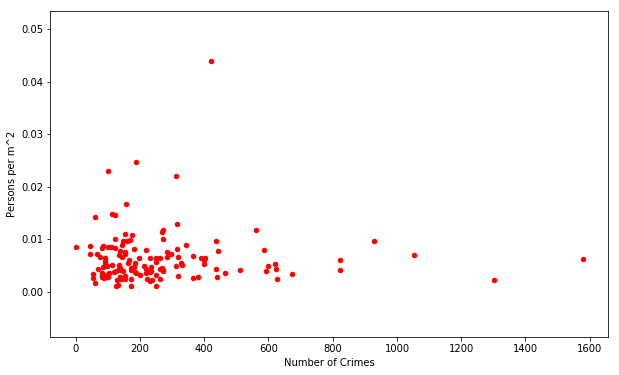

In [11]:
neighborhoods2=neighborhoods2.fillna(0)
crimeToPop =neighborhoods2[["AREA_NAME","Number of Crimes"]]
crimeToPop.loc[:,"Persons per m^2"] = neighborhoods2["Population"]/neighborhoods2["Area m^2"]
neighborhoods2.loc[:,"Persons per m^2"]= neighborhoods2["Population"]/neighborhoods2["Area m^2"]
#neighborhoods2.loc[:,"Crime Rate"]= (neighborhoods2["Crime Rate"]/neighborhoods2["Population"])*100000

crimeToPop.plot(kind='scatter', x='Number of Crimes', y='Persons per m^2', figsize=(10, 6), color='red')
crimeToPop.sort_values("Persons per m^2", ascending=False)
neighborhoods2.sort_values("AREA_NAME", ascending=True).head(5)

Prepare Forusquare request

In [19]:
CLIENT_ID = "WKQBB1DZI22C3IPI4ADEQIKOA1PYAITSAN3NIY3VLMFTNSMG" # your Foursquare ID
CLIENT_SECRET = 'IMZYT4BECBUVICSHJJIHHY00F1I221IO3JOUCAF10RVHBWM3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WKQBB1DZI22C3IPI4ADEQIKOA1PYAITSAN3NIY3VLMFTNSMG
CLIENT_SECRET:IMZYT4BECBUVICSHJJIHHY00F1I221IO3JOUCAF10RVHBWM3


Function to decode the result of the foursquare request

In [27]:
def getNearbyVenues(hoodId, names, latitudes, longitudes,categoryId, radius=500):
    
    venues_list=[]
    for hoodId, name, lat, lng in zip(hoodId, names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT, categoryId)
         
        #print(requests)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print(results)
        # return only relevant information for each nearby venue
        venues_list.append([(
            hoodId,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['hoodId','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Id']
    
    return(nearby_venues)

Parameter and function call of the foursquare function explore

In [28]:


LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
#categoryId = "4d4b7105d754a06374d81259" #food
categoryId = "4bf58dd8d48988d1ca941735" #pizza place

area_venues = getNearbyVenues(hoodId=neighborhoods2['AREA_SHORT_CODE'], names=neighborhoods2['AREA_NAME'],
                                   latitudes=neighborhoods2['LATITUDE'],
                                   longitudes=neighborhoods2['LONGITUDE'], categoryId=categoryId
                                  )
area_venues

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d83951502eb5481e3c71cf5', 'name': 'Pizza Pizza', 'location': {'address': '1571 Sandhurst Circle', 'lat': 43.80831774036611, 'lng': -79.26853687580636, 'labeledLatLngs': [{'label': 'display', 'lat': 43.80831774036611, 'lng': -79.26853687580636}], 'distance': 352, 'postalCode': 'M1V 1V2', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1571 Sandhurst Circle', 'Scarborough ON M1V 1V2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4d83951502eb5481e3c71cf5-0'}]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 

,hoodId,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id
0,129,Agincourt North (129),43.805441,-79.266712,Pizza Pizza,43.808318,-79.268537,Pizza Place,4bf58dd8d48988d1ca941735
1,128,Agincourt South-Malvern West (128),43.788658,-79.265612,Pizza Nova,43.787942,-79.267510,Pizza Place,4bf58dd8d48988d1ca941735
2,128,Agincourt South-Malvern West (128),43.788658,-79.265612,Joey Bravo's Italian Restaurant,43.788071,-79.265134,American Restaurant,4bf58dd8d48988d14e941735
3,20,Alderwood (20),43.604937,-79.541611,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place,4bf58dd8d48988d1ca941735
4,20,Alderwood (20),43.604937,-79.541611,Pizza Pizza,43.605340,-79.547252,Pizza Place,4bf58dd8d48988d1ca941735
5,95,Annex (95),43.671585,-79.404001,Martino's Pizza,43.675560,-79.403558,Pizza Place,4bf58dd8d48988d1ca941735
6,95,Annex (95),43.671585,-79.404001,Pour House,43.675641,-79.403821,Pub,4bf58dd8d48988d11b941735
7,42,Banbury-Don Mills (42),43.737657,-79.349718,Pizza Pizza,43.734579,-79.346290,Pizza Place,4bf58dd8d48988d1ca941735
8,42,Banbury-Don Mills (42),43.737657,-79.349718,Fabbrica,43.736691,-79.344952,Italian Restaurant,4bf58dd8d48988d110941735
9,42,Banbury-Don Mills (42),43.737657,-79.349718,The Good Son,43.735011,-79.344787,Pizza Place,4bf58dd8d48988d1ca941735


The area short code is an unique id which is also used by the data from Toronto's Open Data Platform. By an request for all pizza places you get also similar restaurants.

In [29]:
# one hot encodin
area_onehot = pd.get_dummies(area_venues[['Venue Id']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
area_onehot["AREA_SHORT_CODE"]= ""
area_onehot["AREA_SHORT_CODE"] = area_venues["hoodId"] 

fixed_columns = [area_onehot.columns[-1]] + list(area_onehot.columns[:-1])
area_onehot = area_onehot[fixed_columns]

area_grouped = area_onehot.groupby('AREA_SHORT_CODE').mean().reset_index()
#area_grouped
area_grouped_sum = area_onehot.groupby('AREA_SHORT_CODE').sum().reset_index()
area_grouped = area_grouped.set_index('AREA_SHORT_CODE')
area_grouped_sum = area_grouped_sum.set_index('AREA_SHORT_CODE')
area_grouped_sum








,4bf58dd8d48988d110941735,4bf58dd8d48988d116941735,4bf58dd8d48988d11b941735,4bf58dd8d48988d147941735,4bf58dd8d48988d14e941735,4bf58dd8d48988d16a941735,4bf58dd8d48988d16c941735,4bf58dd8d48988d16d941735,4bf58dd8d48988d16e941735,4bf58dd8d48988d1c4941735,4bf58dd8d48988d1c5941735,4bf58dd8d48988d1ca941735,56aa371ce4b08b9a8d57356c
AREA_SHORT_CODE,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,2,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0
11,0,0,0,0,0,0,0,0,0,0,0,2,0
12,0,0,0,0,0,0,0,0,0,0,0,1,0
14,0,0,0,0,0,0,0,0,0,0,0,1,0
17,0,0,0,0,0,1,0,0,0,0,0,0,0
18,1,0,0,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,0,1,0


Therfore - get the sum the pizza places for each neighborhood.

In [30]:
#neighborhoods2["Probability Venue"]=0
neighborhoods2["Sum Venue"]=0
neighborhoods2 = neighborhoods2.set_index('AREA_SHORT_CODE')

for hoodId, row in area_grouped.iterrows():
    #print(neighborhoods2.loc[hoodId, "AREA_NAME"] + str(area_grouped.loc[hoodId,"4bf58dd8d48988d1ca941735"]))
   # neighborhoods2.loc[hoodId, "Probability Venue"]=area_grouped.loc[hoodId,"4bf58dd8d48988d1ca941735"]
    neighborhoods2.loc[hoodId, "Sum Venue"]=area_grouped_sum.loc[hoodId,"4bf58dd8d48988d1ca941735"]
neighborhoods2.head(5)
#area_grouped


,AREA_NAME,LONGITUDE,LATITUDE,Number of Crimes,Area m^2,Population,Persons per m^2,Sum Venue
AREA_SHORT_CODE,,,,,,,,
129,Agincourt North (129),-79.266712,43.805441,513.0,7264393.0,29113,0.004008,1
128,Agincourt South-Malvern West (128),-79.265612,43.788658,154.0,7875876.0,23757,0.003016,1
20,Alderwood (20),-79.541611,43.604937,223.0,4980675.0,12054,0.002420,2
95,Annex (95),-79.404001,43.671585,154.0,2791395.0,30526,0.010936,1
42,Banbury-Don Mills (42),-79.349718,43.737657,81.0,10045354.0,27695,0.002757,2


The feature have to be scaled to get good results of k-means.

In [31]:
from sklearn.preprocessing import StandardScaler

X = neighborhoods2.values[:,[3, 6 ,7]]



X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 1.09638387e+00, -4.54488796e-01, -7.68149325e-02],
       [-4.53360297e-01, -6.50210893e-01, -7.68149325e-02],
       [-1.55498604e-01, -7.67950258e-01,  4.35284618e-01],
       [-4.53360297e-01,  9.13530980e-01, -7.68149325e-02],
       [-7.68489335e-01, -7.01437768e-01,  4.35284618e-01],
       [ 1.79139449e+00, -5.87704139e-01, -5.88914483e-01],
       [-8.63459729e-01,  1.56850155e+00,  6.06837967e+00],
       [-5.18112839e-01, -4.27247347e-01, -5.88914483e-01],
       [-7.03736793e-01, -6.10855734e-01, -5.88914483e-01],
       [-5.35380184e-01, -4.14719540e-01,  1.45948372e+00],
       [-3.06587869e-01, -5.37857724e-01, -5.88914483e-01],
       [ 6.03432022e-02, -4.52699003e-01, -5.88914483e-01],
       [-6.00132726e-01, -5.13578964e-01, -5.88914483e-01],
       [ 5.69813119e+00, -3.67526381e-03, -5.88914483e-01],
       [-7.64172498e-01,  3.74670423e-01,  9.47384168e-01],
       [-5.18112839e-01,  2.91597037e-01, -7.68149325e-02],
       [-5.74231709e-01, -1.03890083e+00

Execute k-means with different cluster and caluclate the elbow curve. With 5 clusters  the best result can achieved.

Text(0, 0.5, 'costs')

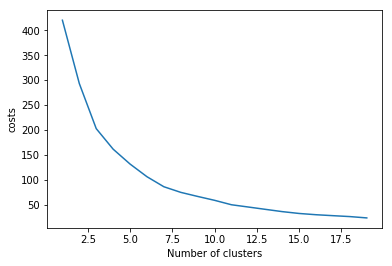

In [59]:
costs =[]
for i in range(1,20):
    k_means = KMeans(init="k-means++", n_clusters=i, n_init=12)
    k_means.fit(cluster_dataset)
    labels = k_means.labels_
    costs.append(k_means.inertia_)
#labels


k_means = KMeans(init="k-means++", n_clusters=5, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_
neighborhoods2["Labels"] = labels

plt.plot(range(1,20),costs)
plt.xlabel("Number of clusters")
plt.ylabel("costs")



The cl

In [61]:
neighborhoods2.groupby('Labels').mean()

,LONGITUDE,LATITUDE,Number of Crimes,Area m^2,Population,Persons per m^2,Sum Venue
Labels,,,,,,,
0,-79.410995,43.718262,187.433735,5.914220e+06,20042.506024,0.004284,0.361446
1,-79.386033,43.673865,157.000000,1.506265e+06,28931.666667,0.019761,10.666667
2,-79.356925,43.729088,810.142857,4.016187e+06,17517.000000,0.005073,0.857143
3,-79.435646,43.663522,303.500000,1.103498e+06,31304.000000,0.034273,1.500000
4,-79.391765,43.685950,218.052632,2.340343e+06,17721.105263,0.008656,2.210526


Plot the clusters into a folium map

In [ ]:

latitude = 43.70460773398059
longitude = -79.39715291165048

map_toronto= folium.Map(location=[latitude, longitude], zoom_start=11)
folium.Choropleth(
    geo_data=gj,  
    data=neighborhoods2,
    columns=['AREA_NAME', 'Number of Crimes'],
    key_on='feature.properties.AREA_NAME',    
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2   
    ).add_to(map_toronto)

colorMap =["black","yellow","red", "orange", "green"]

for lat, lng, neighborhood,klabel in zip(neighborhoods2['LATITUDE'], neighborhoods2['LONGITUDE'], neighborhoods2['AREA_NAME'],neighborhoods2['Labels']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    color=colorMap[klabel]
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        legend="Number of Crimes",
        parse_html=False).add_to(map_toronto) 
map_toronto


